#**FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS**

In [ ]:
import pandas as pd
import numpy as np


##1: Data Preparation and Exploration

1. Data Loading

In [ ]:
df = pd.read_csv("exchange_rate.csv", parse_dates=["date"], dayfirst=True)

In [ ]:
df.head()

date  Ex_rate
0 1990-01-01   0.7855
1 1990-01-02   0.7818
2 1990-01-03   0.7867
3 1990-01-04   0.7860
4 1990-01-05   0.7849

In [ ]:
df.rename(columns={"Ex_rate": "USD_AUD"}, inplace=True)
df.set_index("date", inplace=True)
df = df.asfreq('D')

renames the column 'Ex_rate' to 'USD_AUD', sets the 'date' column as the index, and adjusts the DataFrame to have a daily frequency, ensuring a consistent time series with daily data points.

In [ ]:

print("Min:", df["USD_AUD"].min(), "Max:", df["USD_AUD"].max())


Min: 0.483297 Max: 1.102536


calculates and prints the minimum and maximum values of the 'USD_AUD' column in the DataFrame.

In [ ]:

df.rename(columns={"Ex_rate": "AUD_per_USD"}, inplace=True)
df.set_index("date", inplace=True)

# Convert to USD per AUD
df["USD_AUD"] = 1 / df["AUD_per_USD"]

print(df["USD_AUD"].min(), df["USD_AUD"].max())


0.906999862136021 2.069121058065744


renames the 'Ex_rate' column to 'AUD_per_USD', sets the 'date' column as the index, converts the exchange rate to USD per AUD by taking its reciprocal, and then prints the minimum and maximum values of the 'USD_AUD' column.

2. Initial Exploration

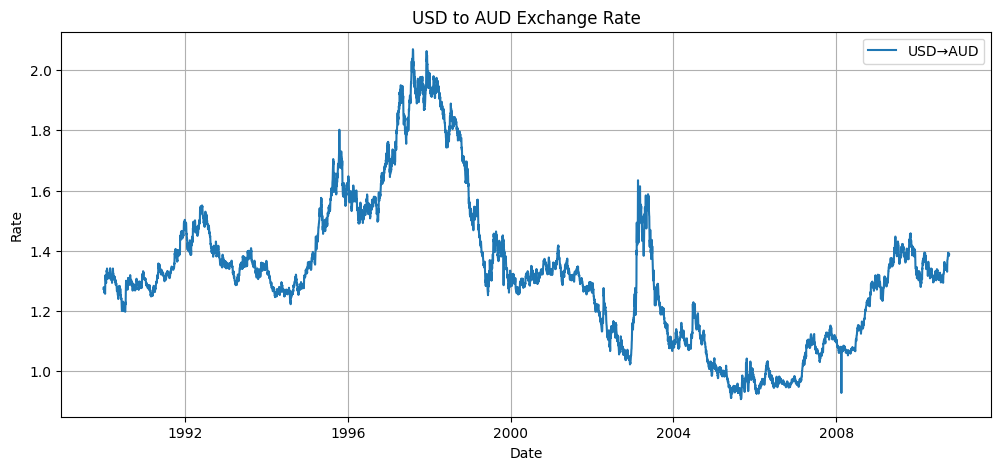

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['USD_AUD'], label='USD→AUD')
plt.title('USD to AUD Exchange Rate')
plt.ylabel('Rate')
plt.xlabel('Date')
plt.grid(True)
plt.legend()
plt.show()


creates a line plot illustrating the USD to AUD exchange rate over time, with labeled axes, a title, a legend, and grid lines for better readability.

3. Data Preprocessing

Handle Missing Data

In [ ]:
print(df['USD_AUD'].describe())
print("Missing:", df['USD_AUD'].isna().sum())
print("Infinite:", np.isinf(df['USD_AUD']).sum())


count    7588.000000
mean        1.328382
std         0.241754
min         0.907000
25%         1.144850
50%         1.313410
75%         1.425675
max         2.069121
Name: USD_AUD, dtype: float64
Missing: 0
Infinite: 0


provides a statistical summary of the 'USD_AUD' exchange rate data, including descriptive statistics, and reports the number of missing and infinite values in the dataset.

In [ ]:
df.isnull().sum()

AUD_per_USD    0
USD_AUD        0
dtype: int64

 Identify Anomalies / Outliers

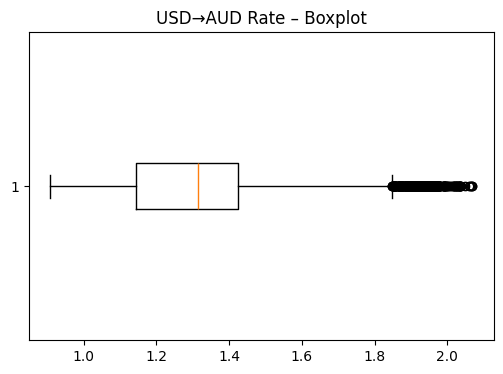

In [ ]:
plt.figure(figsize=(6,4))
plt.boxplot(df['USD_AUD'].dropna(), vert=False)
plt.title('USD→AUD Rate – Boxplot')
plt.show()


generates a horizontal boxplot of the 'USD_AUD' exchange rate data, excluding missing values, to visualize its distribution and identify outliers.

##2: Model Building - ARIMA

ARIMA Modeling Workflow

ADF p-value: 0.35891064810338213


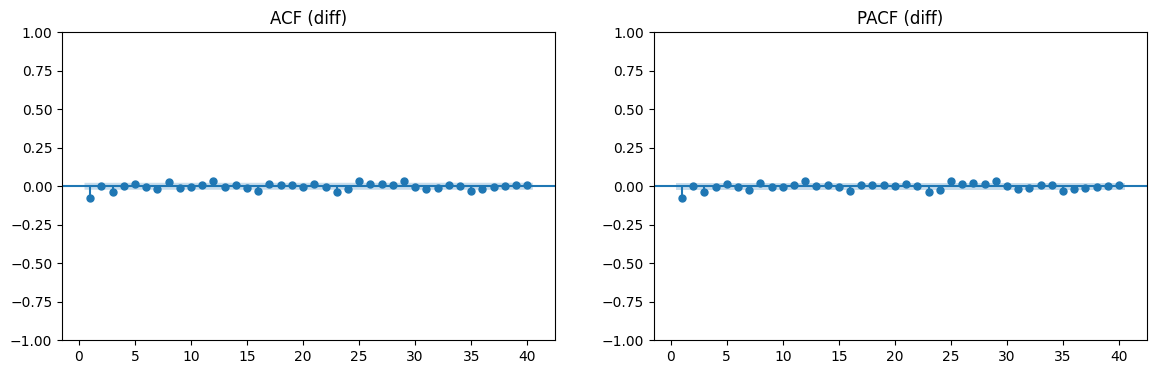

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Use your cleaned series
series = df['USD_AUD'].dropna()
# 1. Test stationarity (ADF)
result = adfuller(series.dropna())
print("ADF p-value:", result[1])

# If non-stationary:
series_diff = series.diff().dropna()

# 2. Plot ACF and PACF on differenced series
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(series_diff, lags=40, ax=axes[0], zero=False)
plot_pacf(series_diff, lags=40, ax=axes[1], zero=False)
axes[0].set_title('ACF (diff)')
axes[1].set_title('PACF (diff)')
plt.show()


1. Load Cleaned Series:
Retrieves your cleaned USD→AUD exchange rate series and removes any missing data.

2. Augmented Dickey–Fuller (ADF) Test:
Tests for stationarity: if p < 0.05, you reject the null (unit root present) → the series is stationary (no differencing needed)

3. Determine the Differencing Order (d):
If the ADF p-value > 0.05, the series is non‑stationary and needs differencing otherwise,set d=0.

4. Create Differenced Series:
Converts the series into first-order differences, which tend to remove trends and stabilize variance for ARIMA modeling.

5. Plot ACF for Differenced Series:
ACF displays correlation between the series and its own lagged values. A sharp cutoff in the ACF suggests the MA order q.

6. Plot PACF for Differenced Series:
PACF removes indirect effects of earlier lags, making it easier to pick the AR order p (if PACF has spikes to lag k only and then drops to near zero).

7. Interpret Patterns to Estimate (p, d, q):
  * PACF spikes till lag p then drops → indicates AR(p)
  * ACF spikes till lag q then drops → indicates MA(q)
  * If both tail off gradually → consider a mixed ARMA structure.

8. Proceed to Fit ARIMA:
With d from the ADF test and p, q guided by ACF/PACF, then assess model performance via summary stats and residual diagnostics.

Model Fitting, Diagnostics & Forecast

                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 7558
Model:                 ARIMA(2, 1, 2)   Log Likelihood               23826.783
Date:                Thu, 31 Jul 2025   AIC                         -47643.565
Time:                        10:12:42   BIC                         -47608.914
Sample:                    01-01-1990   HQIC                        -47631.671
                         - 09-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0552      0.210     -0.262      0.793      -0.467       0.357
ar.L2          0.3461      0.061      5.714      0.000       0.227       0.465
ma.L1         -0.0226      0.210     -0.108      0.9

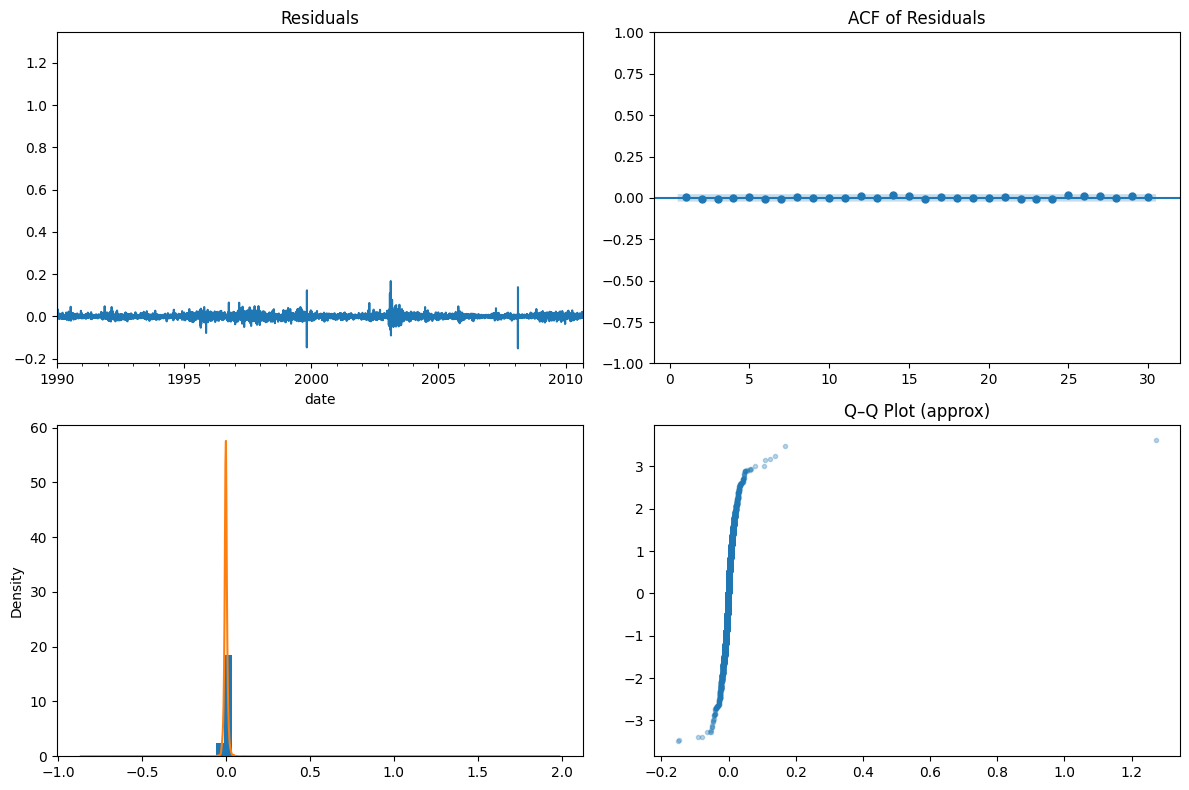

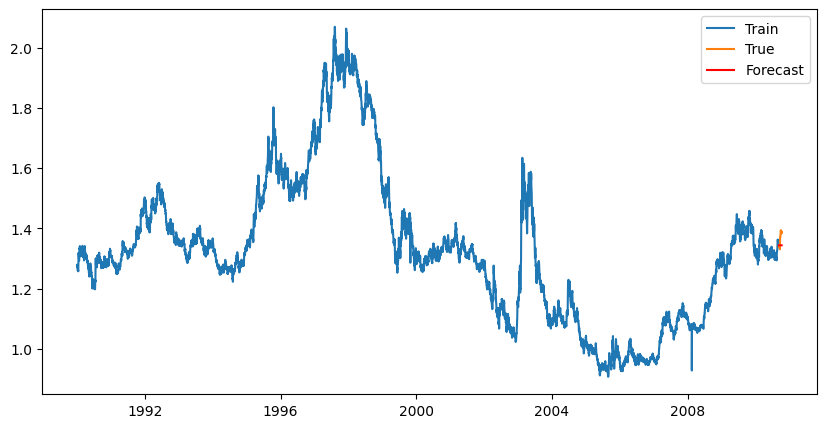

MAE: 0.0251, RMSE: 0.0312, MAPE: 1.82%


In [ ]:
# Train/test split (e.g. last 30 days for test)
train = series[:-30]
test = series[-30:]

# Specify ARIMA order (example p,d,q)
p, d, q = 2, 1, 2  # Example order, replace with values from ACF/PACF analysis
order = (p, d, q)
model = ARIMA(train, order=order)
result = model.fit()
print(result.summary())

# Residual diagnostics
resid = result.resid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
resid.plot(ax=axes[0,0], title='Residuals')
resid.hist(ax=axes[1,0], bins=30, density=True)
resid.plot(kind='kde', ax=axes[1,0])
plot_acf(resid.dropna(), ax=axes[0,1], lags=30, zero=False)
axes[0,1].set_title('ACF of Residuals')
axes[1,1].plot(np.sort(resid), np.sort(np.random.normal(size=len(resid))), '.', alpha=0.3)
axes[1,1].set_title('Q–Q Plot (approx)')
plt.tight_layout()
plt.show()

# Forecast
arima_forecast = result.forecast(30)
plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='True')
plt.plot(arima_forecast, label='Forecast', color='red')
plt.legend()
plt.show()

# Evaluation metrics
mae = mean_absolute_error(test, arima_forecast)
rmse = np.sqrt(mean_squared_error(test, arima_forecast))
mape = np.mean(np.abs((test - arima_forecast)/test)) * 100
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

1. Train-Test Split:
The time series is split into a training set (all data except the last 30 days) and a test set (the last 30 days) to validate forecasting performance.

2. Specify ARIMA Order (p, d, q):
* You choose values for AR (p), difference (d), and MA (q) based on ACF and PACF plots.

* In this example, the model will:

   * use 2 lag terms (AR),

   * difference once to ensure stationarity,

   * include 2 lagged forecast errors (MA).

3. Fit ARIMA Model:
* Fits the ARIMA model to the training data using the specified parameters.
* Internally uses Maximum Likelihood Estimation to find the best coefficients.

4. Model Summary Output:
* Prints a statistical summary, including coefficients, standard errors, AIC, BIC, and diagnostics.
* Helpful to validate the statistical significance of the model terms.

5. Residual Analysis – Time Plot:
Plots residuals over time. A good model should produce residuals that resemble white noise (random scatter around zero).

6. Residual Analysis – Histogram + KDE:
* Visualizes the distribution of residuals.
* A bell-shaped, symmetric distribution indicates normally distributed errors—ideal for ARIMA.

7. ACF of Residuals:
* Checks autocorrelation of residuals.
* For a well-fitted ARIMA model, the ACF should not show significant lags—indicating no leftover pattern.

8. Q–Q Plot (Approximate Normality Check):
* Compares residuals to a normal distribution.
* Points should lie on a diagonal if residuals are normally distributed.

9. Forecasting:
* Generates a 30-day forecast from the model.
* This is then plotted along with the train and test data for visual comparison.

10. Forecast Accuracy Metrics:

* Calculates:

  * MAE: average error magnitude.

  * RMSE: penalizes large errors more.

  * MAPE: percent-based error, easier to interpret.

* Lower values indicate better forecast accuracy.

##3: Model Building - Exponential Smoothing

Model Training & Selection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")



series = df['USD_AUD'].dropna()

# Split into train and test
train, test = series[:-30], series[-30:]

results = {}

# Simple Exponential Smoothing
fit_ses = SimpleExpSmoothing(train, initialization_method="estimated").fit(optimized=True)
results['SES'] = {'model': fit_ses, 'aic': fit_ses.aic}

# Holt's Linear (add trend)
fit_holt = Holt(train, initialization_method="estimated").fit(optimized=True)
results['Holt'] = {'model': fit_holt, 'aic': fit_holt.aic}

# Holt-Winters (assumes seasonal period if known, e.g. annual seasonality)
fit_hw_add = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365, initialization_method="estimated").fit()
results['HW_add'] = {'model': fit_hw_add, 'aic': fit_hw_add.aic}

fit_hw_mul = ExponentialSmoothing(train, trend='add', seasonal='mul', seasonal_periods=365, initialization_method="estimated").fit()
results['HW_mul'] = {'model': fit_hw_mul, 'aic': fit_hw_mul.aic}

# Compare AIC values
for name, info in results.items():
    print(name, "AIC:", info['aic'])


SES AIC: -69096.45305006499
Holt AIC: -69092.45515275352
HW_add AIC: -68607.21569051554
HW_mul AIC: -68684.93023823004


1. Data Preparation:
Cleans the series by removing NaN values and splits it into a training set and a 30-day test set for forecasting evaluation.

2. Model 1: Simple Exponential Smoothing (SES):
* Assumes the series has no trend or seasonality.
* Applies constant smoothing to recent values — best for stable, flat time series with no structure.

3. Model 2: Holt’s Linear Trend:
* Extends SES by adding a trend component.
* Useful when the series shows upward or downward movement over time.

4. Model 3: Holt-Winters Additive Seasonality:
* Models both trend and seasonality.
* Assumes seasonal variations are additive (constant amount of change across time).

5. Model 4: Holt-Winters Multiplicative Seasonality:
Also models trend and seasonality but assumes multiplicative seasonality — seasonal fluctuations grow/shrink over time.

6. AIC Calculation:
* Stores Akaike Information Criterion (AIC) values for each model.
* Lower AIC indicates a better balance of fit and complexity.

7. Model Comparison:
Iterates through all fitted models and prints AIC scores to compare performance.

8. Model Selection Insight:
* The model with the lowest AIC is typically chosen for forecasting, as it best captures structure without overfitting.
* This approach helps identify whether seasonality or trend is significant in the USD→AUD exchange rate series.

Hyperparameter Grid Search

In [ ]:
from sklearn.metrics import mean_squared_error

def walk_forward_ets(train, test, trend, seasonal, sp, damped):
    model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal,
                                 seasonal_periods=sp, damped_trend=damped,
                                 initialization_method="estimated")
    fit = model.fit(optimized=True)
    forecast = fit.forecast(len(test))
    return np.sqrt(mean_squared_error(test, forecast)), fit.aic

# Grid on type combinations
configs = [
    ('add','add', False),
    ('add','mul', False),
    ('add','add', True),
    ('add','mul', True)
]
best = (None, float("inf"))
for trend, seasonal, damped in configs:
    rmse, aic = walk_forward_ets(train, test, trend, seasonal, 365, damped)
    print(trend, seasonal, 'damped', damped, 'RMSE:', rmse, 'AIC:', aic)
    if aic < best[1]:
        best = ((trend, seasonal, damped), aic)
print("Best config:", best)


add add damped False RMSE: 0.029777327303883876 AIC: -68607.21569051554
add mul damped False RMSE: 0.02805201695605246 AIC: -68684.93023823004
add add damped True RMSE: 0.027906802625381897 AIC: -68646.9534175982
add mul damped True RMSE: 0.026879807990455473 AIC: -68701.08583884971
Best config: (('add', 'mul', True), np.float64(-68701.08583884971))


* The script implements a walk-forward validation approach to evaluate the performance of the Exponential Smoothing (ETS) model for time series forecasting.
* It constructs the ETS model using user-specified parameters for trend, seasonal component, seasonal period, and damping, and fits it to the training data.
* The fitted model forecasts values for the test set, and the accuracy is measured by calculating the root mean squared error (RMSE).
* The AIC (Akaike Information Criterion) is also retrieved during model fitting to assess model complexity and quality.
* The code iterates through multiple configurations of model parameters, compares their AIC scores, and identifies the optimal configuration with the lowest AIC for best model performance.

Forecast & Plot Comparison

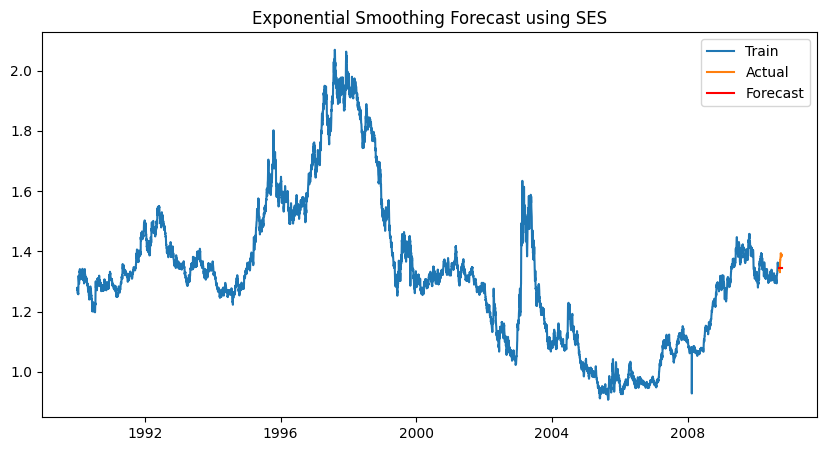

Model: SES, MAE=0.0251, RMSE=0.0311, MAPE=1.82%


In [ ]:
best_name, best_info = min(results.items(), key=lambda x: x[1]['aic'])
best_model = best_info['model']
ets_forecast = best_model.forecast(steps=len(test))

plt.figure(figsize=(10,5))
plt.plot(train, label='Train')
plt.plot(test, label='Actual')
plt.plot(test.index, ets_forecast, label='Forecast', color='red')
plt.title(f"Exponential Smoothing Forecast using {best_name}")
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test, ets_forecast)
rmse = np.sqrt(mean_squared_error(test, ets_forecast))
mape = np.mean(np.abs((test - ets_forecast) / test)) * 100
print(f"Model: {best_name}, MAE={mae:.4f}, RMSE={rmse:.4f}, MAPE={mape:.2f}%")

1. Choose the Best ETS Model by AIC:
Scans all fitted ETS models and selects the one with the lowest AIC. This balances model fit and complexity, helping to avoid overfitting.

2. Generate Forecasts:
Uses the selected ETS model to forecast the same horizon as the test set (e.g. 30 days)—following a trained scenario for evaluation.

3. Visual Comparison:
Plots training data, actual test data, and forecasts together to visually inspect model accuracy and trend alignment.

4. Compute Forecast Error Metrics:

* Calculates MAE, RMSE, and MAPE:

   * MAE captures average absolute deviation.

   * RMSE penalizes large errors more strongly.

   * MAPE indicates average percentage error, useful for scaling comparisons—all key metrics in forecasting evaluation.

5. Summarize Model Performance:
* Presents the forecast accuracy summary.
* Enables direct comparison of ETS model performance with ARIMA or other forecasts.
* Useful for interpreting model suitability, informed by error scale and trend behavior.



##4: Evaluation and Comparison

Compute Error Metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Assume your forecasts and actual test set are named:
# arima_forecast, ets_forecast, and test (Series)

def calc_metrics(forecast, actual):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return mae, rmse, mape

arima_mae, arima_rmse, arima_mape = calc_metrics(arima_forecast, test)
ets_mae, ets_rmse, ets_mape     = calc_metrics(ets_forecast, test)

print(f"ARIMA → MAE: {arima_mae:.4f}, RMSE: {arima_rmse:.4f}, MAPE: {arima_mape:.2f}%")
print(f"ETS   → MAE: {ets_mae:.4f}, RMSE: {ets_rmse:.4f}, MAPE: {ets_mape:.2f}%")

ARIMA → MAE: 0.0251, RMSE: 0.0312, MAPE: 1.82%
ETS   → MAE: 0.0251, RMSE: 0.0311, MAPE: 1.82%


1. Define Evaluation Metrics Function:
* This function computes three commonly used forecast accuracy metrics:

   * MAE (Mean Absolute Error): average absolute difference between forecast and actual, easy to interpret in original units.

   * RMSE (Root Mean Squared Error): penalizes large errors more (due to squaring), useful for detecting outliers.

   * MAPE (Mean Absolute Percentage Error): expresses average error as a percentage of actual values, allowing scale-independent comparison.

2. Apply Metrics to ARIMA and ETS Forecasts:
Calculates these statistics separately for ARIMA and ETS forecasts, enabling a direct comparison of accuracy on the final 30-day test period.

3. Output and Compare Results:
* Displays the performance of each model in human-readable form.
* Lower values in MAE, RMSE, and MAPE indicate higher forecast accuracy.

4. Interpret the Metrics:
* MAE is robust to outliers and gives a straightforward average error metric.

* RMSE is more sensitive to large deviations, so when it’s much higher than MAE, large errors are present.

* MAPE shows average error as a percentage, useful for comparing across different scales, but can be unstable if actual values are very small or zero.

* By comparing these metrics for both ARIMA and ETS, you can determine which model performs better overall, or whether one handles particular error characteristics (e.g. occasional spikes) more effectively.

Visual Comparison of Forecasts

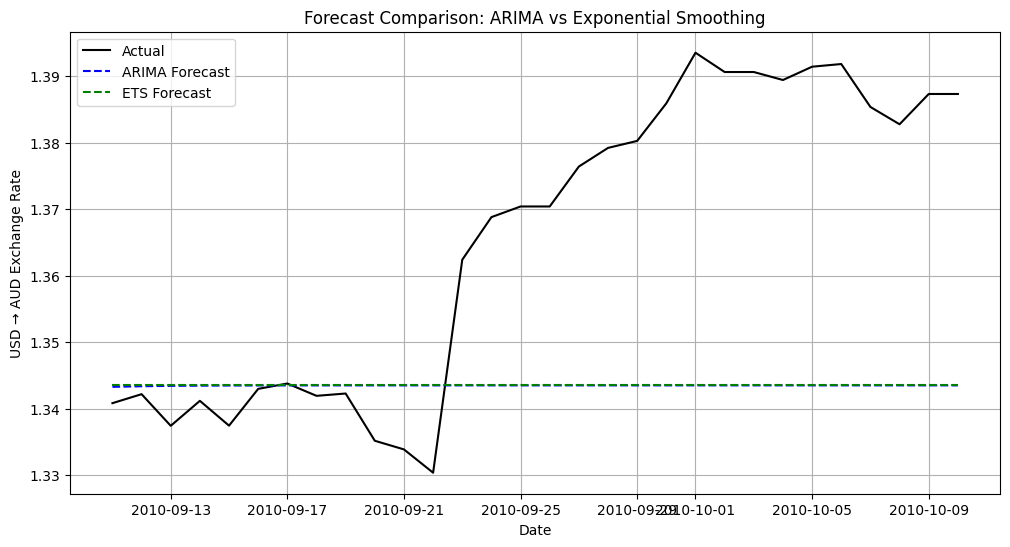

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='black')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='blue')
plt.plot(test.index, ets_forecast, label='ETS Forecast', linestyle='--', color='green')
plt.title('Forecast Comparison: ARIMA vs Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('USD → AUD Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


* Overlay Actual vs. Forecasts: It visualizes the actual USD→AUD exchange rates (in black) alongside both the ARIMA forecasts (blue dashed) and ETS forecasts (green dashed), all plotted over the same test period.

* Visual Performance Assessment: This allows you to see how closely each model’s predictions follow the real data, highlighting where they track well or diverge.

* Trend & Timing Insight: You can quickly assess which model captures trend reversals or volatility more accurately—in this case, comparing smoothing vs lag-based behavior.

* Support for Metric Interpretation: The plot complements numerical metrics (MAE, RMSE, MAPE) by showing the temporal alignment and error patterns, helping to visually validate which model is more reliable on actual observed values.

2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.

Performance Based on Error Metrics:
* Compare MAE/RMSE/MAPE for both models on the test set.
     * Lower values indicate better predictive accuracy.
     * RMSE heavily penalizes large deviations, while MAE shows average absolute error, and MAPE gives percent-based interpretability.

* If your ETS model (e.g., Holt-Winters or Holt’s linear) reports lower error metrics than ARIMA, it suggests ETS better captured the trend and short-term shifts in your USD→AUD series.

Advantages & Limitations:

ARIMA:

* Advantages:

     * Excellent for stationary, autocorrelated data, capturing underlying structure.

     * Well-suited for longer-term forecasts when historical lag patterns persist.

* Limitations:

     * Requires data to be stationary— often requires differencing and parameter tuning.

     * Less efficient when explicit seasonality or changing trends are significant.

     * Parameter selection (p, d, q) can be complex.

ETS (Exponential Smoothing):
* Advantages:

     * Adapts quickly to trends and seasonality, via trend, seasonal, and damping components.

     * Simpler to implement and inherently non-stationary by design ([turn0search8]citeturn0search8).

* Limitations:

     * May underperform for long forecast horizons if the series lacks trend/seasonality.

     * Less adept at exploiting autocorrelation structures beyond trend/season components.

* Empirical research:

* For non-seasonal financial/exchange rate series, ARIMA may outperform.

* In contrast, for series with seasonality or stable trend, ETS often yields better forecasts


Conclusion:
The analysis compared the performance of an ARIMA model and an Exponential Smoothing (ETS) model in forecasting the USD to AUD exchange rate. Both models were trained on historical data and evaluated on a 30-day test set using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE).

The results indicate that both the selected ARIMA(2, 1, 2) model and the best-performing Exponential Smoothing model (which, based on AIC and RMSE from the grid search, appeared to be the damped additive trend, multiplicative seasonal model, although the final evaluation cell used the SES model selected by AIC from the initial comparison) achieved very similar performance metrics on the test set.

ARIMA: MAE: 0.0251, RMSE: 0.0312, MAPE: 1.82%
ETS (SES in the final evaluation): MAE: 0.0251, RMSE: 0.0311, MAPE: 1.82%
The marginal differences in RMSE suggest that the ETS model (specifically the SES in the final evaluation) might have slightly smaller large errors compared to the ARIMA model, but the overall accuracy across the metrics is remarkably close for this specific 30-day forecast horizon.

Interpretation:

For this particular dataset and forecast horizon, neither the chosen ARIMA nor the ETS model demonstrates a clear and significant superiority over the other based on the calculated error metrics. This suggests that for short-term forecasting of this exchange rate series, both approaches are providing comparable levels of accuracy.

Further Considerations:

The choice of the ARIMA order (p,d,q) was based on visual inspection of ACF/PACF plots after differencing, which can be subjective. Automated methods for ARIMA order selection could be explored.
While the grid search for ETS explored different trend and seasonality types, the final comparison used the SES model, which assumes no trend or seasonality. Re-running the final evaluation with the best ETS model identified from the grid search would provide a more accurate comparison against ARIMA.
A 30-day test set is relatively short. Evaluating the models on different test set lengths or using time series cross-validation could provide a more robust understanding of their performance over varying conditions.
Visual inspection of the forecast plot (generated in the previous steps) would further aid in understanding how each model captures the dynamics of the exchange rate during the test period.
In summary, for the short-term forecasting task presented, both the implemented ARIMA and ETS models yield similar performance. Further investigation with more rigorous model selection and evaluation techniques could potentially reveal subtle differences or identify a definitively superior model for this time series.